In [ ]:
!pip install db-sqlite3 lxml selenium

In [ ]:
!apt-get update 
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin


In [3]:
import sqlite3
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.action_chains import ActionChains
import time
import re
import pandas as pd
import matplotlib.pyplot as plt

Se crea la  BBDD

In [4]:
conn = sqlite3.connect('mydatabase.db')
print("Opened database successfully")
cur = conn.cursor()

Opened database successfully


Se crean las tablas LUGAR y VUELO

In [5]:
cur.execute("CREATE TABLE IF NOT EXISTS lugar (descripcion  CHAR(50))")
cur.execute("CREATE TABLE IF NOT EXISTS vuelo (origen INTEGER, destino INTEGER, compania CHAR(50), escalaida INTEGER, tiempoida REAL, escalavuelta INTEGER, tiempovuelta INTEGER ,precio REAL)")

In [6]:
cur.execute("INSERT INTO lugar(descripcion) VALUES('CORDOBA')")
cur.execute("INSERT INTO lugar(descripcion) VALUES('MADRID')")
cur.execute("INSERT INTO lugar(descripcion) VALUES('BUENOS-AIRES')")
conn.commit()

Función que nos permite realizar el Web scraping

In [7]:
def resultado(url):
  SCROLL_PAUSE_TIME = 0.5
  options = webdriver.ChromeOptions()
  options.add_argument('--headless')
  options.add_argument('--no-sandbox')
  options.add_argument('--disable-dev-shm-usage')
  options.add_argument('--ignore-certificate-errors')
  options.add_argument('--incognito')

  driver = webdriver.Chrome('chromedriver',options=options)

  last_height = driver.execute_script("return document.body.scrollHeight")

  # open web page
  driver.get(url)
  WebDriverWait(driver, 30).until(EC.presence_of_element_located((By.CLASS_NAME, 'COMMON')))
  while True:
    # Scroll down to bottom
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")

    # Wait to load page
    time.sleep(SCROLL_PAUSE_TIME)

    # Calculate new scroll height and compare with last scroll height
    new_height = driver.execute_script("return document.body.scrollHeight")
    if new_height == last_height:
        break
    last_height = new_height
    #WebDriverWait(driver, 40).until(EC.presence_of_all_elements_located((By.TAG_NAME,'cluster')))

  html = driver.page_source
  soup = BeautifulSoup(html, 'html.parser') 
  return soup

Se conecta al sitio web despegar. Se busca los vuelos Córdoba - Madrid

In [8]:
soup = resultado('https://www.despegar.com.ar/shop/flights/results/roundtrip/COR/MAD/2022-12-01/2022-12-14/1/0/0/NA/NA/NA/NA/NA?from=SB&di=1-0')

Se realiza insert a la tabla vuelo 

In [9]:
name = soup.find_all('cluster', class_='COMMON')
for link in name:
  compania = link.find('span', class_='name').get_text().lstrip()
  precio = link.find('div', class_='fare-detail-items').find_all('span', class_='amount price-amount')[2].get_text()
  way = link.find_all('span', class_='sub-cluster');
  ida = way[0].find('span', class_='stops-wrapper text').get_text() 
  vuelta = way[1].find('span', class_='stops-wrapper text').get_text() 
  escala_ida = ida[1]
  minutos_i = ida[16:19].lstrip().replace('m','')
  if minutos_i == '':
    minutos_i = '0'
  tiempo_ida = str(float(ida[11:14]) + (float(minutos_i) / 60))
  minutos = vuelta[16:18].lstrip().replace('m','')
  if minutos == '':
    minutos = '0'
  escala_vuelta = vuelta[1]
  tiempo_vuelta = str(float(vuelta[11:14]) + (float(minutos) / 60))
  cur.execute("INSERT INTO vuelo VALUES (1, 2, '"+ compania +"',"+ escala_ida +"," + tiempo_ida +"," + escala_vuelta +","+ tiempo_vuelta + "," + precio + ")")
  conn.commit()

In [10]:
cordoba_vuelo = pd.read_sql("SELECT L.descripcion as origen, L2.descripcion as destino, V.compania, V.escalaida, V.tiempoida, V.escalavuelta, V.tiempovuelta, V.precio FROM vuelo V INNER JOIN lugar L ON V.origen = L.rowid INNER JOIN lugar L2 on V.destino = L2.rowid where V.origen = 1 and V.destino = 2", conn)

In [12]:
cordoba_vuelo

,origen,destino,compania,escalaida,tiempoida,escalavuelta,tiempovuelta,precio
0,CORDOBA,MADRID,Aerolíneas Argentinas,1,20.500000,1,17.750000,497.792
1,CORDOBA,MADRID,LATAM,2,48.266667,2,38.050000,441.945
2,CORDOBA,MADRID,LATAM,2,50.166667,2,38.050000,438.009
3,CORDOBA,MADRID,Aerolíneas Argentinas,1,20.500000,1,18.583333,557.065
4,CORDOBA,MADRID,LATAM,2,48.266667,2,49.083333,421.023
5,CORDOBA,MADRID,LATAM,2,50.166667,2,49.083333,417.085
6,CORDOBA,MADRID,LATAM,2,48.266667,1,33.333333,469.129
7,CORDOBA,MADRID,LATAM,2,50.166667,1,33.333333,465.192
8,CORDOBA,MADRID,LATAM,2,47.083333,2,38.050000,461.093
9,CORDOBA,MADRID,LATAM,2,45.350000,2,38.050000,468.619


Se muestan los resultados que solo tengan una escala

In [13]:
filt = (cordoba_vuelo['escalaida'] == 1) & (cordoba_vuelo['escalavuelta'] == 1)
cordoba_vuelo.loc[filt]

,origen,destino,compania,escalaida,tiempoida,escalavuelta,tiempovuelta,precio
0,CORDOBA,MADRID,Aerolíneas Argentinas,1,20.5,1,17.750000,497.792
3,CORDOBA,MADRID,Aerolíneas Argentinas,1,20.5,1,18.583333,557.065


Vuelo de mayor precio


In [14]:
filt = cordoba_vuelo['precio'].idxmax()
cordoba_vuelo.loc[filt]

origen            CORDOBA
destino            MADRID
compania           LATAM 
escalaida               2
tiempoida           21.35
escalavuelta            1
tiempovuelta    33.333333
precio            559.732
Name: 22, dtype: object

Vuelo de menor precio

In [15]:
filt = cordoba_vuelo['precio'].idxmin()
cordoba_vuelo.loc[filt]

origen            CORDOBA
destino            MADRID
compania           LATAM 
escalaida               2
tiempoida       50.166667
escalavuelta            2
tiempovuelta    49.083333
precio            417.085
Name: 5, dtype: object

Mediana de los vuelos

In [16]:
cordoba_vuelo['precio'].median()


481.467

Gráfico de Precios

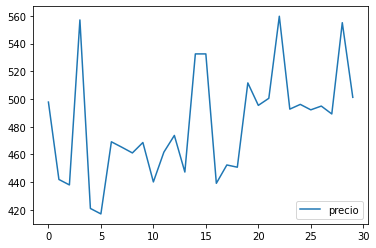

In [17]:
cordoba_vuelo[['precio']].plot()

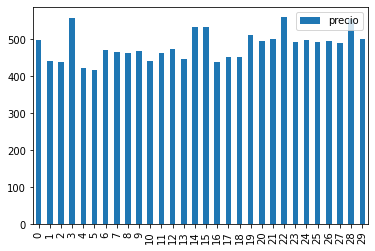

In [18]:
cordoba_vuelo[['precio']].plot(kind='bar')

Se conecta al sitio web despegar. Se busca los vuelos Buenos Aires - Madrid

In [19]:
soup = resultado('https://www.despegar.com.ar/shop/flights/results/roundtrip/BUE/MAD/2022-12-01/2022-12-14/1/0/0/NA/NA/NA/NA/NA?from=SB&di=1-0')

In [20]:
name = soup.find_all('cluster', class_='COMMON')
for link in name:
  compania = link.find('span', class_='name').get_text().lstrip()
  precio = link.find('span', class_='fare-wrapper -eva-3-p-md').find_all('span', class_='amount price-amount')[0].get_text()
  way = link.find_all('span', class_='sub-cluster');
  ida = way[0].find('span', class_='stops-wrapper text').get_text() 
  vuelta = way[1].find('span', class_='stops-wrapper text').get_text() 
  escala_ida = ida[1]
  if not escala_ida.isnumeric():
    escala_ida = '0'
  minutos_i = ida[16:19].lstrip().replace('m','')
  if minutos_i == '':
    minutos_i = '0'
  horas_i = ida[10:14].lstrip().replace('h','')
  tiempo_ida = str(float(horas_i) + (float(minutos_i) / 60))
  escala_vuelta = vuelta[1]
  if not escala_vuelta.isnumeric():
    escala_vuelta = '0'     
  minutos = vuelta[16:18].lstrip().replace('m','')
  if minutos == '':
    minutos = '0'
  horas_v = vuelta[10:14].lstrip().replace('h','')  
  tiempo_vuelta = str(float(horas_v) + (float(minutos) / 60))
  cur.execute("INSERT INTO vuelo VALUES ({}, {}, '{}', {}, {}, {}, {}, {})".format(3, 2, compania, escala_ida, tiempo_ida, escala_vuelta, tiempo_vuelta, precio))
  conn.commit()


In [21]:
bsas_vuelo = pd.read_sql("SELECT L.descripcion as origen, L2.descripcion as destino, V.compania, V.escalaida, V.tiempoida, V.escalavuelta, V.tiempovuelta, V.precio FROM vuelo V INNER JOIN lugar L ON V.origen = L.rowid INNER JOIN lugar L2 on V.destino = L2.rowid where V.origen = 3 and V.destino = 2", conn)

In [22]:
bsas_vuelo

,origen,destino,compania,escalaida,tiempoida,escalavuelta,tiempovuelta,precio
0,BUENOS-AIRES,MADRID,LATAM,2,23.000000,1,27.166667,368.969
1,BUENOS-AIRES,MADRID,LATAM,2,23.000000,1,30.500000,368.969
2,BUENOS-AIRES,MADRID,LATAM,2,23.000000,2,29.050000,373.097
3,BUENOS-AIRES,MADRID,LATAM,2,23.666667,1,27.166667,388.304
4,BUENOS-AIRES,MADRID,LATAM,2,23.000000,2,38.050000,368.459
5,BUENOS-AIRES,MADRID,LATAM,1,14.750000,1,27.166667,417.269
6,BUENOS-AIRES,MADRID,LATAM,2,23.666667,1,30.500000,388.304
7,BUENOS-AIRES,MADRID,LATAM,1,14.750000,1,30.500000,417.269
8,BUENOS-AIRES,MADRID,Aerolíneas Argentinas,0,12.083333,0,13.000000,472.468
9,BUENOS-AIRES,MADRID,LATAM,2,21.833333,1,27.166667,415.429


In [23]:
filt = (bsas_vuelo['escalaida'] == 1) & (bsas_vuelo['escalavuelta'] == 1)
bsas_vuelo.loc[filt]

,origen,destino,compania,escalaida,tiempoida,escalavuelta,tiempovuelta,precio
5,BUENOS-AIRES,MADRID,LATAM,1,14.750000,1,27.166667,417.269
7,BUENOS-AIRES,MADRID,LATAM,1,14.750000,1,30.500000,417.269
13,BUENOS-AIRES,MADRID,LATAM,1,35.083333,1,27.166667,392.472
15,BUENOS-AIRES,MADRID,Air France,1,16.666667,1,17.750000,469.725
16,BUENOS-AIRES,MADRID,LATAM,1,35.083333,1,30.500000,392.472
17,BUENOS-AIRES,MADRID,LATAM,1,28.750000,1,27.166667,418.494
19,BUENOS-AIRES,MADRID,LATAM,1,14.750000,1,27.166667,456.402
22,BUENOS-AIRES,MADRID,Air France,1,16.666667,1,17.750000,477.224
23,BUENOS-AIRES,MADRID,LATAM,1,28.750000,1,30.500000,418.494


Vuelo de mayor precio

In [24]:
filt = bsas_vuelo['precio'].idxmax()
bsas_vuelo.loc[filt]

origen          BUENOS-AIRES
destino               MADRID
compania         Air France 
escalaida                  1
tiempoida          16.666667
escalavuelta               1
tiempovuelta           17.75
precio               477.224
Name: 22, dtype: object

Vuelo de menor precio

In [25]:
filt = bsas_vuelo['precio'].idxmin()
bsas_vuelo.loc[filt]

origen          BUENOS-AIRES
destino               MADRID
compania              LATAM 
escalaida                  2
tiempoida               23.0
escalavuelta               2
tiempovuelta           38.05
precio               368.459
Name: 4, dtype: object

Mediana de los vuelos

In [26]:
bsas_vuelo['precio'].median()


417.269

Gráfico de Precios

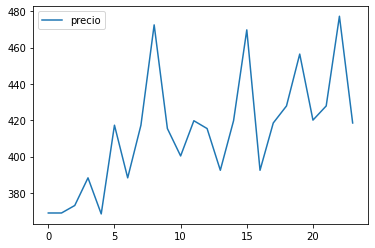

In [27]:
bsas_vuelo[['precio']].plot()

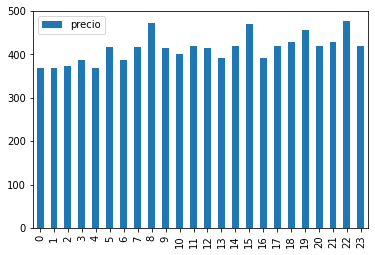

In [28]:
bsas_vuelo[['precio']].plot(kind='bar')

In [29]:
cordoba_precio = cordoba_vuelo['precio']
bsas_precio = bsas_vuelo['precio']

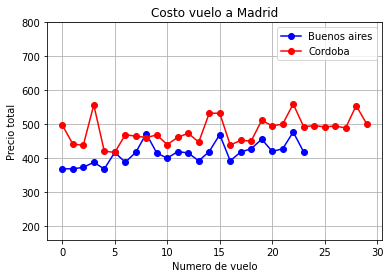

In [39]:
fig, ax = plt.subplots()
ax.plot(bsas_precio, '-ob', label= 'Buenos aires')
ax.plot(cordoba_precio,'-or', label= 'Cordoba')
ax.set(xlabel = 'Numero de vuelo',ylabel ='Precio total',
       title = 'Costo vuelo a Madrid')
ax.set_ylim([160, 800])
ax.legend()
ax.grid()
plt.show()